In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("data.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

rfm.head()

,Recency,Frequency,Monetary,AOV
CustomerID,,,,
12346.0,326,1,77183.60,77183.600000
12347.0,2,7,4310.00,615.714286
12348.0,75,4,1797.24,449.310000
12349.0,19,1,1757.55,1757.550000
12350.0,310,1,334.40,334.400000


In [5]:
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Monetary']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 230.04565054147486
RMSE: 2236.1189169546888


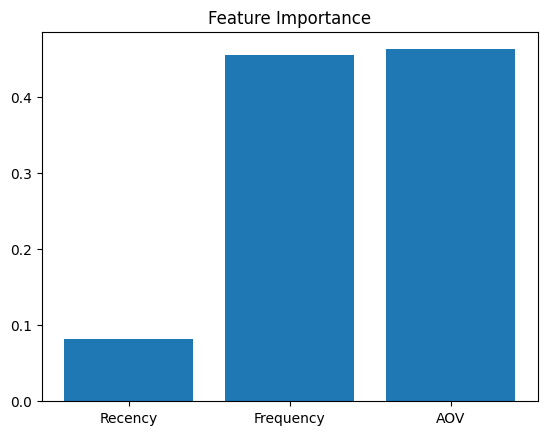

In [9]:
importances = model.feature_importances_
features = X.columns

plt.figure()
plt.bar(features, importances)
plt.title("Feature Importance")
plt.show()

In [10]:
rfm['Predicted_LTV'] = model.predict(X)
rfm.head()

,Recency,Frequency,Monetary,AOV,Predicted_LTV
CustomerID,,,,,
12346.0,326,1,77183.60,77183.600000,78266.6680
12347.0,2,7,4310.00,615.714286,4318.4675
12348.0,75,4,1797.24,449.310000,1795.4965
12349.0,19,1,1757.55,1757.550000,1762.3372
12350.0,310,1,334.40,334.400000,334.5087


In [11]:
rfm['Segment'] = pd.qcut(
    rfm['Predicted_LTV'],
    q=3,
    labels=['Low Value', 'Medium Value', 'High Value']
)

rfm['Segment'].value_counts()

Segment
Low Value       1446
Medium Value    1446
High Value      1446
Name: count, dtype: int64

In [12]:
rfm.to_csv("Final_LTV_Predictions.csv")

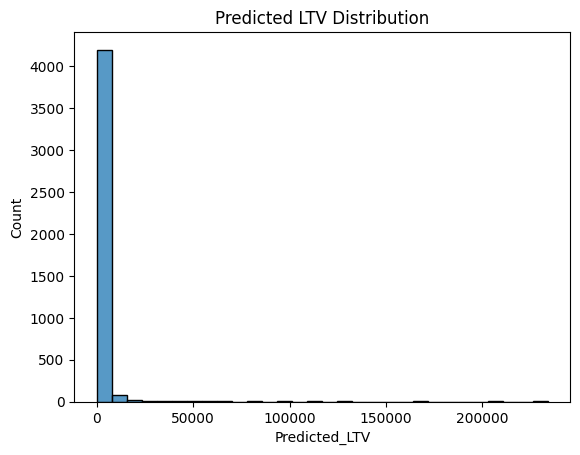

In [13]:
plt.figure()
sns.histplot(rfm['Predicted_LTV'], bins=30)
plt.title("Predicted LTV Distribution")
plt.show()

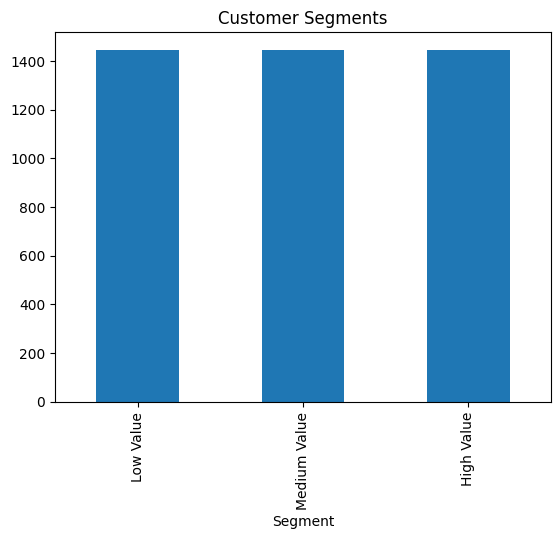

In [14]:
plt.figure()
rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customer Segments")
plt.show()